In [3]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install trimesh
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import scipy.io
import logging
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import torchvision.transforms as transforms
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from torchvision.utils import make_grid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 11.5 MB/s eta 0:00:00 0:00:01


In [8]:
# masks.classes

['bed',
 'bookcase',
 'chair',
 'desk',
 'misc',
 'sofa',
 'table',
 'tool',
 'wardrobe']

# 3D-Pix2Pix 1st trial

In [2]:
logging.basicConfig(level=logging.INFO)

class Pix3DJSONDataset(Dataset):
    def __init__(self, base_dir, json_file, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.data = self.load_json(json_file)

    def load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        logging.info(f"Loaded {len(data)} samples from JSON file")
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Load image
        img_path = os.path.join(self.base_dir, item['img'])
        image = self.load_image(img_path)
        
        # Load 3D model (as voxel)
        voxel_path = os.path.join(self.base_dir, item['voxel'])
        voxel = self.load_voxel(voxel_path)
        
        # Get category
        category = item['category']
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        voxel = torch.from_numpy(voxel).float()

        return image, voxel, category

    def load_image(self, path):
        try:
            with Image.open(path) as img:
                return img.convert('RGB')
        except Exception as e:
            logging.error(f"Error loading image {path}: {str(e)}")
            raise

    def load_voxel(self, path):
        try:
            voxel_data = scipy.io.loadmat(path)
            voxel = voxel_data['voxel'].astype(np.float32)
            return voxel
        except Exception as e:
            logging.error(f"Error loading voxel {path}: {str(e)}")
            raise



In [3]:
# Define transforms
transform = transforms.Compose([
#         transforms.Grayscale(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
base_dir = '/kaggle/input/pix3d-dataset'
json_file = '/kaggle/input/pix3d-dataset/pix3d.json'  # Adjust this path as needed
dataset = Pix3DJSONDataset(base_dir, json_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [12]:
# Print some information about the dataset
print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Try to get the first batch
first_batch = next(iter(dataloader))
print(f"First batch shapes:")
print(f"  Images: {first_batch[0].shape}")
print(f"  Voxels: {first_batch[1].shape}")
print(f"First batch categories: {first_batch[2]}")


Dataset size: 10069
Number of batches: 10069
First batch shapes:
  Images: torch.Size([1, 3, 128, 128])
  Voxels: torch.Size([1, 128, 128, 128])
First batch categories: ('chair',)


In [5]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [6]:
def downsample_volume(volume, scale_factor=0.5):
    downsampled = F.interpolate(volume, scale_factor=scale_factor, mode='nearest')
    return downsampled.squeeze()

In [7]:
# Matplotlib visualization (faster, simplified)
def get_volume_views(volume, downsample=True, scale_factor=0.5):
    if downsample:
        volume = downsample_volume(volume, scale_factor)
    volume = volume.squeeze().detach().numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(volume, edgecolor='k')  # No edges for faster rendering
    
    # Save or display
    plt.show()
    plt.close()


In [8]:
for batch in dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128, 128])


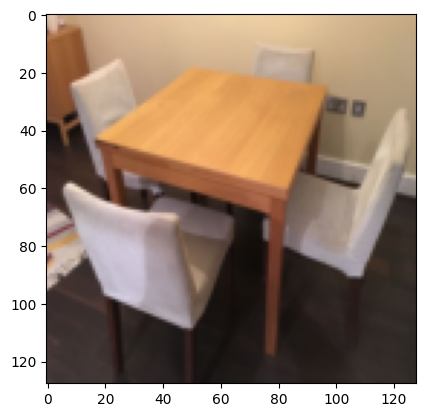

In [12]:
show_tensor_images(batch[0][0])

In [30]:
batch[1][0].shape

torch.Size([128, 128, 128])

In [ ]:
get_volume_views(batch[1][0], downsample=True, scale_factor=0.25)

# Generator

In [9]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',drop=False,norm=True):
        super().__init__()
        self.drop=drop
        self.norm=norm
        self.dropout=nn.Dropout(0.5)
        if self.norm==True:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose3d(in_channels,out_channels,4,2,1),
                nn.BatchNorm2d(out_channels) if down else nn.BatchNorm3d(out_channels),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
        else:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose3d(in_channels,out_channels,4,2,1),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
            
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [10]:
class Generator(nn.Module):
    def __init__(self,hidden_dim=32,in_channels=3):
        super(Generator,self).__init__() 
        self.down1=Block(in_channels,hidden_dim,down=True,act='leaky',drop=False)
        self.down2=Block(hidden_dim,hidden_dim*2,down=True,act='leaky',drop=False)
        self.down3=Block(hidden_dim*2,hidden_dim*4,down=True,act='leaky',drop=False)        
        self.down4=Block(hidden_dim*4,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down5=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)
        self.down6=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)
        self.down7=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False,norm=False)
 
        self.bottleneck=nn.Sequential(
            nn.Conv3d(hidden_dim*8,hidden_dim*8,3,2,1),
            nn.ReLU()
        )
        
        self.up1=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up2=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up3=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up4=Block(hidden_dim*8*2,hidden_dim*4,down=False,act='relu',drop=True)
        self.up5=Block(hidden_dim*4*2,hidden_dim*2,down=False,act='relu',drop=True)
        self.up6=Block(hidden_dim*2*2,hidden_dim,down=False,act='relu',drop=True)
        self.up7=Block(hidden_dim*2,1,down=False,act='relu',drop=True)
        
        self.final_up=nn.Sequential(
            nn.ConvTranspose3d(hidden_dim*2,in_channels,4,2,1),
            nn.Tanh()
        )
        
    def forward(self,x):
        d1=self.down1(x)
#         print("down1: ",d1.shape) #[BATCH_SIZE,32,64,64]
        d2=self.down2(d1)
#         print("down2: ",d2.shape) #[BATCH_SIZE,64,32,32]
        d3=self.down3(d2)
#         print("down3: ",d3.shape) #[BATCH_SIZE,128,16,16]
        d4=self.down4(d3)
#         print("down4: ",d4.shape) #[BATCH_SIZE,256,8,8]
        d5=self.down5(d4)
#         print("down5: ",d5.shape) #[BATCH_SIZE,256,4,4]
        d6=self.down6(d5)
#         print("down6: ",d6.shape) #[BATCH_SIZE,256,2,2]
        d7=self.down7(d6)
#         print("down7: ",d7.shape) #[BATCH_SIZE,256,1,1]
        

        d7_resh=d7.view(-1,256,1,1,1)
#         print("down7 reshaped: ",d7_resh.shape) #[BATCH_SIZE,256,1,1,1]
#         print("="*50)

        bottleneck=self.bottleneck(d7_resh)
#         print("bottleneck: ",bottleneck.shape) #[BATCH_SIZE, 256, 1, 1, 1]
        
#         print("="*50)
        
        up1=self.up1(torch.cat([bottleneck,d7_resh],dim=1))
#         print("up1: ",up1.shape) #[BATCH_SIZE, 256, 2, 2, 2]
        
        d6_resh=d6.view(-1,256,2,2,1).repeat(1,1,1,1,2)
        up2=self.up2(torch.cat([up1,d6_resh],dim=1))
#         print("up2: ",up2.shape) #[BATCH_SIZE, 256, 4, 4, 4]
        d5_resh=d5.view(-1,256,4,4,1).repeat(1,1,1,1,4)
        up3=self.up3(torch.cat([up2,d5_resh],dim=1))
#         print("up3: ",up3.shape) #[BATCH_SIZE, 256, 8, 8, 8]
        d4_resh=d4.view(-1,256,8,8,1).repeat(1,1,1,1,8)
        up4=self.up4(torch.cat([up3,d4_resh],dim=1))
#         print("up4: ",up4.shape) #[BATCH_SIZE, 128, 16, 16, 16]
        d3_resh=d3.view(-1,128,16,16,1).repeat(1,1,1,1,16)
        up5=self.up5(torch.cat([up4,d3_resh],dim=1))
#         print("up5: ",up5.shape) #[BATCH_SIZE, 64, 32, 32, 32]
        d2_resh=d2.view(-1,64,32,32,1).repeat(1,1,1,1,32)
        up6=self.up6(torch.cat([up5,d2_resh],dim=1))
#         print("up6: ",up6.shape) #[BATCH_SIZE, 32, 64, 64,64]
        d1_resh=d1.view(-1,32,64,64,1).repeat(1,1,1,1,64)
        up7=self.up7(torch.cat([up6,d1_resh],dim=1))
#         print("up7: ",up7.shape) #[BATCH_SIZE, 1, 128,128, 128]
        
        return up7.squeeze(0)
#         return up7

In [11]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',drop=False):
        super().__init__()
        self.drop=drop
        self.dropout=nn.Dropout(0.5)
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [12]:
class Generator(nn.Module):
    def __init__(self,in_channels=3,hidden_dim=64):
        super().__init__()
        self.init_down=nn.Sequential(
            nn.Conv2d(in_channels,hidden_dim,4,2,1),
            nn.LeakyReLU(0.2),
        )
        self.down1=Block(hidden_dim,hidden_dim*2,down=True,act='leaky',drop=False)
        self.down2=Block(hidden_dim*2,hidden_dim*4,down=True,act='leaky',drop=False)        
        self.down3=Block(hidden_dim*4,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down4=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down5=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down6=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False) 
        
        self.bottleneck=nn.Sequential(
            nn.Conv2d(hidden_dim*8,hidden_dim*8,4,2,1),
            nn.ReLU()
        )
        
        self.up1=Block(hidden_dim*8,hidden_dim*8,down=False,act='relu',drop=True)
        self.up2=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up3=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up4=Block(hidden_dim*8*2,hidden_dim*4,down=False,act='relu',drop=True)        
        self.up5=Block(hidden_dim*4*2,hidden_dim*2,down=False,act='relu',drop=True)        
        self.up6=Block(hidden_dim*2*2,hidden_dim,down=False,act='relu',drop=True)        
        self.up7=Block(hidden_dim*2,hidden_dim,down=False,act='relu',drop=True)
        
        self.final_up=nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2,128,4,2,1),
            nn.Tanh()
        )
#         self.final_layer=nn.Se
        
    def forward(self,x):
        d1 = self.init_down(x)
#         print(f'd1 shape: {d1.shape}')
        
        d2 = self.down1(d1)
#         print(f'd2 shape: {d2.shape}')
        
        d3 = self.down2(d2)
#         print(f'd3 shape: {d3.shape}')
        
        d4 = self.down3(d3)
#         print(f'd4 shape: {d4.shape}')
        
        d5 = self.down4(d4)
#         print(f'd5 shape: {d5.shape}')
        
        d6 = self.down5(d5)
#         print(f'd6 shape: {d6.shape}')
        
#         d7 = self.down6(d6)
#         print(f'd7 shape: {d7.shape}')
        
        bottleneck = self.bottleneck(d6)
#         print(f'bottleneck shape: {bottleneck.shape}')
        
        up1 = self.up1(bottleneck)
#         print(f'up1 shape: {up1.shape}')
        
        up2 = self.up2(torch.cat([up1, d6], 1))
#         print(f'up2 shape: {up2.shape}')
        
        up3 = self.up3(torch.cat([up2, d5], 1))
#         print(f'up3 shape: {up3.shape}')
        
        up4 = self.up4(torch.cat([up3, d4], 1))
#         print(f'up4 shape: {up4.shape}')
        
        up5 = self.up5(torch.cat([up4, d3], 1))
# #         print(f'up5 shape: {up5.shape}')
        
        up6 = self.up6(torch.cat([up5, d2], 1))
#         print(f'up6 shape: {up6.shape}')
        
        up7 = self.final_up(torch.cat([up6, d1], 1))
#         print(f'up7 shape: {up7.shape}')
        
        
        return up7

## Gen test

In [15]:
d6=torch.rand(1,256,2,2).view(-1,256,2,2,1).repeat(1,1,1,1,2)
d6.shape

torch.Size([1, 256, 2, 2, 2])

In [23]:
gen=Generator()

In [24]:
img=torch.rand(1,3,128,128)

In [25]:
x=gen(img)
x.shape

torch.Size([1, 128, 128, 128])

In [343]:
print(x.shape)

torch.Size([1, 128, 128, 128])


# Discriminator

In [62]:
get_volume_views(x[0],downsample=True,scale_factor=0.25)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7df7f1348670> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7df7f132f910> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [13]:
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2,last=False):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride,1),
                nn.BatchNorm2d(out_channels) if not last else nn.Identity(),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.conv(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=32):
        super().__init__()
        self.d1=CNN_Block(in_channels+128,hidden_dim)
        self.d2=CNN_Block(hidden_dim,hidden_dim*2)
        self.d3=CNN_Block(hidden_dim*2,hidden_dim*4)
        self.d4=CNN_Block(hidden_dim*4,hidden_dim*8)
        self.d5=CNN_Block(hidden_dim*8,hidden_dim*8)
        self.d6=CNN_Block(hidden_dim*8,hidden_dim*16)
        self.d7=CNN_Block(hidden_dim*16,1,last=True)
        
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1)
        x=self.d1(x)
        x=self.d2(x)        
        x=self.d3(x)        
        x=self.d4(x)        
        x=self.d5(x)
        x=self.d6(x)
        x=self.d7(x)
        return x

In [58]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features = [64,128,256,512,512,1024]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels+128, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNN_Block(in_channels, feature, stride=1 if feature==features[-1] else 2)
                
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )
        self.last= nn.Sequential(
            nn.Conv2d(in_channels+128, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x,y):
        x = torch.cat([x,y],dim=1)
        
#         x=x.unsqueeze(0)
#         print(x.shape)
        x = self.initial(x)
        return self.model(x)
    

## Disc test

In [69]:
disc2to3=Discriminator()

In [66]:
disc=Disc()

In [67]:
img=torch.rand(1,3,128,128)
mask=torch.rand(1,128,128,128)
disc(batch[0],batch[1]).shape

torch.Size([1, 1, 1, 1])

In [56]:
batch[1].shape

torch.Size([1, 128, 128, 128])

In [70]:
img=torch.rand(1,3,128,128)
mask=torch.rand(1,128,128,128)
disc2to3(batch[0],batch[1]).shape

torch.Size([1, 1, 1, 1])

# Init

In [25]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [26]:
gen=Generator().cuda()
disc=Discriminator().cuda()

In [27]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [28]:
LR=0.0002
BETAS=(0.5,0.999)
LAMBDA=100
EPOCHS=10

In [29]:
gen_opt=torch.optim.Adam(gen.parameters(),lr=LR,betas=BETAS)
disc_opt=torch.optim.Adam(disc.parameters(),lr=LR,betas=BETAS)

In [30]:
BCE_Loss=nn.BCEWithLogitsLoss()
L1_Loss=nn.L1Loss()

In [33]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import numpy as np

def train_pix2pix_3d(gen, disc, dataloader, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gen.to(device)
    disc.to(device)

    # Loss functions
    BCE_Loss = nn.BCELoss()
    L1_Loss = nn.L1Loss()

    # Hyperparameters
    LAMBDA = 100  # L1 loss weight
    LEARNING_RATE = 0.0002
    BETA1 = 0.5
    BETA2 = 0.999

    # Optimizers
    gen_opt = Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
    disc_opt = Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

    # Learning rate schedulers
    gen_scheduler = StepLR(gen_opt, step_size=30, gamma=0.1)
    disc_scheduler = StepLR(disc_opt, step_size=30, gamma=0.1)

    for epoch in range(num_epochs):
        gen.train()
        disc.train()
        
        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            d2 = batch[0].to(device)  # 2D input image
            d3_real = batch[1].to(device)  # 3D target image

            # Generate fake 3D image
            d3_fake = gen(d2)
            
            # Check if generator output is valid
            if torch.isnan(d3_fake).any() or torch.isinf(d3_fake).any():
                print(f"Warning: Generator output contains NaN or Inf at epoch {epoch+1}, batch {batch_idx+1}")
                continue

            # Train Discriminator
            disc_opt.zero_grad()

            # Real images
            D_real = disc(d2, d3_real)
            D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real))

            # Fake images
            D_fake = disc(d2, d3_fake.detach())
            D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake))

            # Combined discriminator loss
            D_loss = (D_real_loss + D_fake_loss) / 2
            D_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1)
            
            disc_opt.step()

            # Train Generator
            gen_opt.zero_grad()

            # Generator tries to fool discriminator
            D_fake = disc(d2, d3_fake)
            G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))

            # L1 loss between generated and real 3D images
            L1 = L1_Loss(d3_fake, d3_real) * LAMBDA

            # Combined generator loss
            G_loss = G_fake_loss + L1
            G_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1)
            
            gen_opt.step()

            # Print losses every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}:")
                print(f"  Generator loss: {G_loss.item():.4f}")
                print(f"  Discriminator loss: {D_loss.item():.4f}")
                print(f"  L1 loss: {L1.item():.4f}")
                print(f"  Fake image min/max/mean: {d3_fake.min().item():.4f}/{d3_fake.max().item():.4f}/{d3_fake.mean().item():.4f}")

        # Step the learning rate schedulers
        gen_scheduler.step()
        disc_scheduler.step()

In [34]:
train_pix2pix_3d(gen, disc, dataloader, num_epochs=100)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [93]:
gen(batch[0]).shape

torch.Size([1, 128, 128, 128])

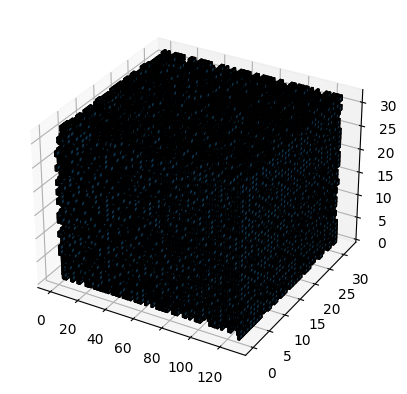

In [99]:
gen=gen.cpu()
get_volume_views(d3_fake.cpu(), downsample=True, scale_factor=0.25)

In [137]:
gen=gen.cuda()

In [31]:
gen_losses=[]
disc_losses=[]

In [32]:
iteration=0
for epoch in range(10):
    for batch in tqdm(dataloader):
        iteration+=1
        d2=batch[0]
        d3=batch[1]
        d2=d2.cuda()
        d3=d3.cuda()
        d3_fake=gen(d2)
#         print(d2.shape)
#         print(d3.shape)

        D_real=disc(d2,d3)
        
        D_real_loss=BCE_Loss(D_real,torch.ones_like(D_real))
        
        D_fake=disc(d2,d3_fake.detach())
        D_fake_loss=BCE_Loss(D_fake,torch.zeros_like(D_fake))
        D_loss=(D_real_loss+D_fake_loss)/2
        disc.zero_grad()
        D_loss.backward()
        disc_opt.step()
        
        D_fake=disc(d2,d3_fake)
        G_fake_loss=BCE_Loss(D_fake,torch.ones_like(D_fake))
        L1=L1_Loss(d3_fake,d3)*LAMBDA
        G_loss=G_fake_loss+L1
        
        gen_opt.zero_grad()
        G_loss.backward()
        gen_opt.step() 
        #================================================================
        #================================================================
#         
        #================================================================
        #================================================================
        if iteration % 150 == 0 and iteration > 0:
            print(f"Step {iteration}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
            gen_losses.append(G_loss)
            disc_losses.append(D_loss)

#             generate_images(gen,s['B'].cuda(),s['A'].cuda())
        
        
        

  0%|          | 0/10069 [00:00<?, ?it/s]

Step 150: Generator loss: 3.6056361198425293, discriminator loss: 0.727317214012146
Step 300: Generator loss: 3.0558528900146484, discriminator loss: 0.1883983165025711
Step 450: Generator loss: 3.592188596725464, discriminator loss: 0.09652270376682281
Step 600: Generator loss: 3.3336563110351562, discriminator loss: 0.045178379863500595
Step 750: Generator loss: 5.33357572555542, discriminator loss: 3.533203363418579
Step 900: Generator loss: 7.210849761962891, discriminator loss: 0.5077029466629028


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 1050: Generator loss: 5.088520526885986, discriminator loss: 0.07752939313650131
Step 1200: Generator loss: 3.577646255493164, discriminator loss: 0.19093334674835205
Step 1350: Generator loss: 6.131772518157959, discriminator loss: 0.3213462829589844
Step 1500: Generator loss: 15.855768203735352, discriminator loss: 0.057688526809215546
Step 1650: Generator loss: 24.854660034179688, discriminator loss: 0.1948576271533966
Step 1800: Generator loss: 9.688690185546875, discriminator loss: 0.07286019623279572
Step 1950: Generator loss: 8.203154563903809, discriminator loss: 0.08146758377552032
Step 2100: Generator loss: 8.44309139251709, discriminator loss: 0.09711380302906036
Step 2250: Generator loss: 4.259393692016602, discriminator loss: 0.052371494472026825
Step 2400: Generator loss: 12.777944564819336, discriminator loss: 0.06979436427354813
Step 2550: Generator loss: 5.19596004486084, discriminator loss: 0.059881746768951416
Step 2700: Generator loss: 8.05375862121582, discrim

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 5250: Generator loss: 10.095681190490723, discriminator loss: 0.10178658366203308
Step 5400: Generator loss: 7.668252944946289, discriminator loss: 0.0349896140396595
Step 5550: Generator loss: 11.959590911865234, discriminator loss: 0.3152619004249573
Step 5700: Generator loss: 6.0898518562316895, discriminator loss: 0.08768852055072784
Step 5850: Generator loss: 7.400753974914551, discriminator loss: 0.5479512214660645
Step 6000: Generator loss: 9.874661445617676, discriminator loss: 0.1725291758775711
Step 6150: Generator loss: 6.174010276794434, discriminator loss: 0.04236298054456711
Step 6300: Generator loss: 11.04547119140625, discriminator loss: 0.007371759042143822
Step 6450: Generator loss: 20.78427505493164, discriminator loss: 0.01772710494697094
Step 6600: Generator loss: 10.998653411865234, discriminator loss: 0.009161493740975857
Step 6750: Generator loss: 6.842419624328613, discriminator loss: 0.014316663146018982
Step 6900: Generator loss: 7.839876651763916, discr

  0%|          | 0/10069 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 10200: Generator loss: 36.148258209228516, discriminator loss: 0.0033851489424705505
Step 10350: Generator loss: 12.372175216674805, discriminator loss: 0.007414830848574638
Step 10500: Generator loss: 13.007694244384766, discriminator loss: 0.005406072363257408
Step 10650: Generator loss: 21.94595718383789, discriminator loss: 0.07181920856237411
Step 10800: Generator loss: 8.382064819335938, discriminator loss: 0.004698188044130802
Step 10950: Generator loss: 11.415853500366211, discriminator loss: 0.014829193241894245
Step 11100: Generator loss: 8.284640312194824, discriminator loss: 0.010075761936604977
Step 11250: Generator loss: 9.505512237548828, discriminator loss: 0.0024691917933523655
Step 11400: Generator loss: 8.309591293334961, discriminator loss: 0.0941607877612114
Step 11550: Generator loss: 13.541208267211914, discriminator loss: 0.00729672284796834
Step 11700: Generator loss: 6.153061866760254, discriminator loss: 0.05713820457458496
Step 11850: Generator loss: 6.

  0%|          | 0/10069 [00:00<?, ?it/s]

Step 20250: Generator loss: 4.189393997192383, discriminator loss: 0.7866261005401611
Step 20400: Generator loss: 14.265527725219727, discriminator loss: 0.006748583633452654
Step 20550: Generator loss: 11.28183650970459, discriminator loss: 0.004045229405164719
Step 20700: Generator loss: 15.335948944091797, discriminator loss: 0.003599725430831313
Step 20850: Generator loss: 13.639910697937012, discriminator loss: 0.00335916830226779
Step 21000: Generator loss: 7.584587097167969, discriminator loss: 0.0024706118274480104
Step 21150: Generator loss: 35.799530029296875, discriminator loss: 0.005676859524101019
Step 21300: Generator loss: 5.810158729553223, discriminator loss: 0.042971283197402954
Step 21450: Generator loss: 19.033538818359375, discriminator loss: 0.010541584342718124
Step 21600: Generator loss: 8.604681968688965, discriminator loss: 0.023919852450489998
Step 21750: Generator loss: 7.289412498474121, discriminator loss: 0.005261136684566736
Step 21900: Generator loss: 1

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del_

Step 28650: Generator loss: 7.056321620941162, discriminator loss: 0.0044472673907876015
Step 28800: Generator loss: 6.3463544845581055, discriminator loss: 0.01196683943271637
Step 28950: Generator loss: 11.085325241088867, discriminator loss: 0.0019292471697553992
Step 29100: Generator loss: 29.467357635498047, discriminator loss: 0.023061838001012802
Step 29250: Generator loss: 8.443225860595703, discriminator loss: 0.03360704332590103
Step 29400: Generator loss: 6.015713691711426, discriminator loss: 0.04447009786963463
Step 29550: Generator loss: 7.079395294189453, discriminator loss: 0.022733911871910095
Step 29700: Generator loss: 28.43604850769043, discriminator loss: 0.07267989963293076
Step 29850: Generator loss: 9.37673282623291, discriminator loss: 0.0038862410001456738
Step 30000: Generator loss: 9.303812026977539, discriminator loss: 0.01191346999257803


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del_

Step 30150: Generator loss: 14.714588165283203, discriminator loss: 0.0028840231243520975


  0%|          | 0/10069 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>    Exception ignored in: self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
if w.is_alive():    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Traceback (most recent call last):

Step 30300: Generator loss: 11.267059326171875, discriminator loss: 0.0065384842455387115
Step 30450: Generator loss: 13.828662872314453, discriminator loss: 0.04682599753141403
Step 30600: Generator loss: 7.993180751800537, discriminator loss: 0.0029863452073186636
Step 30750: Generator loss: 7.409581661224365, discriminator loss: 0.6373540163040161
Step 30900: Generator loss: 10.831188201904297, discriminator loss: 0.39632511138916016
Step 31050: Generator loss: 10.122265815734863, discriminator loss: 0.010026957839727402
Step 31200: Generator loss: 14.620160102844238, discriminator loss: 0.011023704893887043
Step 31350: Generator loss: 8.567266464233398, discriminator loss: 0.012743976898491383
Step 31500: Generator loss: 6.741540908813477, discriminator loss: 0.002545128343626857


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 34350: Generator loss: 21.646135330200195, discriminator loss: 0.015500334091484547
Step 34500: Generator loss: 14.29020881652832, discriminator loss: 0.013588370755314827
Step 34650: Generator loss: 11.721498489379883, discriminator loss: 0.0015790305333212018
Step 34800: Generator loss: 21.474960327148438, discriminator loss: 0.0034735845401883125
Step 34950: Generator loss: 7.173544883728027, discriminator loss: 0.009337048046290874
Step 35100: Generator loss: 14.128588676452637, discriminator loss: 0.09169499576091766
Step 35250: Generator loss: 13.261246681213379, discriminator loss: 1.9701924324035645
Step 35400: Generator loss: 15.711103439331055, discriminator loss: 0.004714622627943754
Step 35550: Generator loss: 10.015353202819824, discriminator loss: 0.012723568826913834
Step 35700: Generator loss: 15.418296813964844, discriminator loss: 0.004465627018362284
Step 35850: Generator loss: 16.773670196533203, discriminator loss: 0.042438093572854996
Step 36000: Generator lo

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 37650: Generator loss: 5.983403205871582, discriminator loss: 1.7251031398773193
Step 37800: Generator loss: 6.8725996017456055, discriminator loss: 0.09439989179372787
Step 37950: Generator loss: 10.783896446228027, discriminator loss: 0.0013417428126558661


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 38100: Generator loss: 9.905492782592773, discriminator loss: 0.006817934103310108
Step 38250: Generator loss: 6.033041000366211, discriminator loss: 0.06849595904350281
Step 38400: Generator loss: 17.890031814575195, discriminator loss: 0.01276252418756485
Step 38550: Generator loss: 10.251741409301758, discriminator loss: 0.0029657972045242786
Step 38700: Generator loss: 5.578021049499512, discriminator loss: 0.01967981643974781


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 43650: Generator loss: 11.874509811401367, discriminator loss: 0.009420455433428288
Step 43800: Generator loss: 9.483972549438477, discriminator loss: 0.0037603960372507572
Step 43950: Generator loss: 20.04803466796875, discriminator loss: 0.0015717546921223402
Step 44100: Generator loss: 9.383415222167969, discriminator loss: 0.04295273870229721
Step 44250: Generator loss: 11.41147518157959, discriminator loss: 0.0024674462620168924
Step 44400: Generator loss: 9.648889541625977, discriminator loss: 1.5308337211608887
Step 44550: Generator loss: 5.376804828643799, discriminator loss: 0.023095963522791862
Step 44700: Generator loss: 9.816946029663086, discriminator loss: 0.029803583398461342
Step 44850: Generator loss: 16.465879440307617, discriminator loss: 0.0012286261189728975
Step 45000: Generator loss: 16.839813232421875, discriminator loss: 0.00282856123521924
Step 45150: Generator loss: 8.300888061523438, discriminator loss: 0.0017966952873393893
Step 45300: Generator loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 51300: Generator loss: 16.51605224609375, discriminator loss: 0.0035524421837180853
Step 51450: Generator loss: 9.901554107666016, discriminator loss: 2.3941597938537598
Step 51600: Generator loss: 11.335882186889648, discriminator loss: 0.05269092321395874
Step 51750: Generator loss: 15.965507507324219, discriminator loss: 0.0066015166230499744
Step 51900: Generator loss: 19.752431869506836, discriminator loss: 0.0021983622573316097
Step 52050: Generator loss: 13.289816856384277, discriminator loss: 0.001395426457747817
Step 52200: Generator loss: 11.65251636505127, discriminator loss: 0.01424074824899435
Step 52350: Generator loss: 13.582571029663086, discriminator loss: 0.012244791723787785
Step 52500: Generator loss: 7.265631198883057, discriminator loss: 0.0033198753371834755
Step 52650: Generator loss: 14.988086700439453, discriminator loss: 0.0004895533784292638
Step 52800: Generator loss: 16.7244930267334, discriminator loss: 0.00040655137854628265
Step 52950: Generator lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 59250: Generator loss: 14.564014434814453, discriminator loss: 0.000681583012919873
Step 59400: Generator loss: 8.548110008239746, discriminator loss: 0.009347235783934593
Step 59550: Generator loss: 31.188512802124023, discriminator loss: 0.011804969049990177
Step 59700: Generator loss: 10.441462516784668, discriminator loss: 0.031501609832048416
Step 59850: Generator loss: 15.55188274383545, discriminator loss: 0.0025164633989334106
Step 60000: Generator loss: 8.778172492980957, discriminator loss: 0.003614154178649187
Step 60150: Generator loss: 7.314239501953125, discriminator loss: 0.0017407960258424282
Step 60300: Generator loss: 16.201868057250977, discriminator loss: 0.0018806583248078823


  0%|          | 0/10069 [00:00<?, ?it/s]

Step 60450: Generator loss: 7.140569686889648, discriminator loss: 0.08073421567678452
Step 60600: Generator loss: 16.081111907958984, discriminator loss: 0.014004923403263092
Step 60750: Generator loss: 8.224808692932129, discriminator loss: 0.0062631480395793915
Step 60900: Generator loss: 11.59475326538086, discriminator loss: 0.0037828152999281883
Step 61050: Generator loss: 15.769267082214355, discriminator loss: 0.002163397381082177
Step 61200: Generator loss: 13.238548278808594, discriminator loss: 0.0021063489839434624
Step 61350: Generator loss: 10.13814640045166, discriminator loss: 0.002208372112363577
Step 61500: Generator loss: 15.875919342041016, discriminator loss: 0.006870057433843613
Step 61650: Generator loss: 9.318700790405273, discriminator loss: 0.006648381240665913


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 61800: Generator loss: 12.476277351379395, discriminator loss: 0.000980130978859961
Step 61950: Generator loss: 8.659252166748047, discriminator loss: 0.001516510616056621
Step 62100: Generator loss: 7.809605598449707, discriminator loss: 0.0025982740335166454
Step 62250: Generator loss: 8.069519996643066, discriminator loss: 0.438092440366745
Step 62400: Generator loss: 8.312047004699707, discriminator loss: 0.008305292576551437
Step 62550: Generator loss: 8.717082023620605, discriminator loss: 0.003640583250671625
Step 62700: Generator loss: 11.34848690032959, discriminator loss: 0.0007445249357260764
Step 62850: Generator loss: 17.98658561706543, discriminator loss: 0.008474807254970074
Step 63000: Generator loss: 14.972548484802246, discriminator loss: 0.0018628775142133236
Step 63150: Generator loss: 11.851253509521484, discriminator loss: 0.0012944837799295783
Step 63300: Generator loss: 23.225378036499023, discriminator loss: 0.003980276174843311
Step 63450: Generator loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 66450: Generator loss: 11.14535140991211, discriminator loss: 0.06032754108309746
Step 66600: Generator loss: 15.9152250289917, discriminator loss: 0.0003035533882211894
Step 66750: Generator loss: 20.73727035522461, discriminator loss: 0.008297896012663841
Step 66900: Generator loss: 15.808329582214355, discriminator loss: 0.004288928117603064
Step 67050: Generator loss: 12.354028701782227, discriminator loss: 0.003559724660590291
Step 67200: Generator loss: 17.151466369628906, discriminator loss: 0.0024457848630845547
Step 67350: Generator loss: 9.057353019714355, discriminator loss: 0.002514785621315241
Step 67500: Generator loss: 10.851613998413086, discriminator loss: 0.0015893547097221017
Step 67650: Generator loss: 16.805940628051758, discriminator loss: 0.0017769110854715109
Step 67800: Generator loss: 8.194438934326172, discriminator loss: 0.0034459829330444336
Step 67950: Generator loss: 10.396123886108398, discriminator loss: 0.0003893181565217674
Step 68100: Generator 

  0%|          | 0/10069 [00:00<?, ?it/s]

Step 70500: Generator loss: 9.490812301635742, discriminator loss: 0.006893342360854149
Step 70650: Generator loss: 8.956503868103027, discriminator loss: 0.08917340636253357
Step 70800: Generator loss: 16.536638259887695, discriminator loss: 0.019664691761136055
Step 70950: Generator loss: 6.898188591003418, discriminator loss: 0.03679250553250313
Step 71100: Generator loss: 11.953780174255371, discriminator loss: 0.007097535766661167
Step 71250: Generator loss: 32.73837661743164, discriminator loss: 0.0007698070257902145
Step 71400: Generator loss: 15.203250885009766, discriminator loss: 0.09386806935071945
Step 71550: Generator loss: 11.331727027893066, discriminator loss: 0.0027970559895038605
Step 71700: Generator loss: 9.161783218383789, discriminator loss: 0.006053917109966278
Step 71850: Generator loss: 10.250617980957031, discriminator loss: 0.0004454153822734952
Step 72000: Generator loss: 10.79371452331543, discriminator loss: 0.0015429880004376173
Step 72150: Generator loss

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 74400: Generator loss: 7.1795196533203125, discriminator loss: 0.0023550193291157484
Step 74550: Generator loss: 11.062793731689453, discriminator loss: 0.0031029346864670515
Step 74700: Generator loss: 11.602746963500977, discriminator loss: 0.0013312936061993241
Step 74850: Generator loss: 9.16507625579834, discriminator loss: 0.017193302512168884
Step 75000: Generator loss: 9.737895011901855, discriminator loss: 0.004593231715261936
Step 75150: Generator loss: 10.356206893920898, discriminator loss: 0.006410758011043072
Step 75300: Generator loss: 18.11043357849121, discriminator loss: 0.0008782779914326966
Step 75450: Generator loss: 16.2117919921875, discriminator loss: 0.0008105013403110206
Step 75600: Generator loss: 7.553762435913086, discriminator loss: 0.00881750788539648
Step 75750: Generator loss: 14.312095642089844, discriminator loss: 0.01616513356566429
Step 75900: Generator loss: 13.908445358276367, discriminator loss: 0.0013003195635974407
Step 76050: Generator lo

  0%|          | 0/10069 [00:00<?, ?it/s]

Step 80700: Generator loss: 9.10658073425293, discriminator loss: 0.0029549456667155027
Step 80850: Generator loss: 36.512306213378906, discriminator loss: 0.0036544830072671175
Step 81000: Generator loss: 14.889297485351562, discriminator loss: 0.004778133239597082
Step 81150: Generator loss: 14.045928001403809, discriminator loss: 0.0014014882035553455
Step 81300: Generator loss: 10.266390800476074, discriminator loss: 0.0014675623970106244
Step 81450: Generator loss: 19.791282653808594, discriminator loss: 0.0010431531118229032
Step 81600: Generator loss: 13.26126480102539, discriminator loss: 0.0010745611507445574
Step 81750: Generator loss: 11.78304672241211, discriminator loss: 0.0006369351176545024
Step 81900: Generator loss: 8.089581489562988, discriminator loss: 0.002915690653026104
Step 82050: Generator loss: 50.79355239868164, discriminator loss: 0.0072093745693564415
Step 82200: Generator loss: 9.936616897583008, discriminator loss: 0.0022723334841430187
Step 82350: Generat

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 82500: Generator loss: 46.328277587890625, discriminator loss: 0.029304347932338715
Step 82650: Generator loss: 10.339984893798828, discriminator loss: 0.001375915831886232
Step 82800: Generator loss: 6.390519142150879, discriminator loss: 0.12606452405452728
Step 82950: Generator loss: 10.579742431640625, discriminator loss: 0.04350334778428078
Step 83100: Generator loss: 12.188048362731934, discriminator loss: 0.002923390129581094
Step 83250: Generator loss: 7.519773483276367, discriminator loss: 0.00994904339313507
Step 83400: Generator loss: 14.999476432800293, discriminator loss: 0.026768758893013
Step 83550: Generator loss: 8.857881546020508, discriminator loss: 0.005474169738590717
Step 83700: Generator loss: 8.374077796936035, discriminator loss: 0.0006551706464961171
Step 83850: Generator loss: 8.975261688232422, discriminator loss: 0.027465004473924637
Step 84000: Generator loss: 51.44362258911133, discriminator loss: 0.0004238587280269712
Step 84150: Generator loss: 10.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

    if w.is_alive():
  File "/op

Step 86700: Generator loss: 7.1693267822265625, discriminator loss: 0.005064182914793491
Step 86850: Generator loss: 12.071901321411133, discriminator loss: 0.0018175640143454075
Step 87000: Generator loss: 9.281988143920898, discriminator loss: 0.07351739704608917
Step 87150: Generator loss: 12.294414520263672, discriminator loss: 0.0006700879312120378
Step 87300: Generator loss: 19.53768539428711, discriminator loss: 0.00997182447463274
Step 87450: Generator loss: 28.359176635742188, discriminator loss: 0.0017591770738363266
Step 87600: Generator loss: 20.744625091552734, discriminator loss: 0.0004791008250322193
Step 87750: Generator loss: 15.56822681427002, discriminator loss: 0.00114019017200917
Step 87900: Generator loss: 13.31979751586914, discriminator loss: 0.0007721688016317785
Step 88050: Generator loss: 8.492940902709961, discriminator loss: 0.02668718434870243
Step 88200: Generator loss: 7.73750638961792, discriminator loss: 0.003041135845705867
Step 88350: Generator loss:

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 88500: Generator loss: 33.857276916503906, discriminator loss: 0.0015495598781853914
Step 88650: Generator loss: 10.353386878967285, discriminator loss: 0.04696209728717804
Step 88800: Generator loss: 11.456083297729492, discriminator loss: 0.00754449563100934
Step 88950: Generator loss: 7.031540870666504, discriminator loss: 0.04403635114431381
Step 89100: Generator loss: 21.534265518188477, discriminator loss: 0.0011211243690922856
Step 89250: Generator loss: 15.667797088623047, discriminator loss: 0.010705101303756237
Step 89400: Generator loss: 10.229256629943848, discriminator loss: 0.0006748525775037706


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Step 89550: Generator loss: 9.748018264770508, discriminator loss: 0.008830427192151546
Step 89700: Generator loss: 11.905313491821289, discriminator loss: 0.008903679437935352
Step 89850: Generator loss: 18.176273345947266, discriminator loss: 0.041520047932863235
Step 90000: Generator loss: 12.293931007385254, discriminator loss: 0.0006615572492592037
Step 90150: Generator loss: 15.50905990600586, discriminator loss: 0.007693865802139044
Step 90300: Generator loss: 10.130372047424316, discriminator loss: 0.0005934283253736794
Step 90450: Generator loss: 15.691524505615234, discriminator loss: 0.006444472819566727
Step 90600: Generator loss: 11.504178047180176, discriminator loss: 0.0029969429597258568


  0%|          | 0/10069 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560><function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in: self._shutdown_workers()      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd9a649a560>

      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

Traceback (most recent call last):
  File "/opt/con

Step 90750: Generator loss: 21.40962791442871, discriminator loss: 0.0034575010649859905
Step 90900: Generator loss: 15.960933685302734, discriminator loss: 0.005480675492435694
Step 91050: Generator loss: 10.26774787902832, discriminator loss: 0.0010759909637272358
Step 91200: Generator loss: 18.632389068603516, discriminator loss: 0.0006326445727609098
Step 91350: Generator loss: 8.860465049743652, discriminator loss: 0.0007075182511471212
Step 91500: Generator loss: 9.96327018737793, discriminator loss: 0.0012805876322090626
Step 91650: Generator loss: 12.647115707397461, discriminator loss: 0.0030157507862895727
Step 91800: Generator loss: 9.189455032348633, discriminator loss: 0.0073683117516338825


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 91950: Generator loss: 11.876468658447266, discriminator loss: 0.008052024058997631
Step 92100: Generator loss: 11.569547653198242, discriminator loss: 0.001678437925875187
Step 92250: Generator loss: 20.801116943359375, discriminator loss: 0.0013131577288731933
Step 92400: Generator loss: 21.166868209838867, discriminator loss: 0.02025613561272621
Step 92550: Generator loss: 16.492849349975586, discriminator loss: 0.00392746040597558
Step 92700: Generator loss: 11.977962493896484, discriminator loss: 0.00350965466350317
Step 92850: Generator loss: 13.617443084716797, discriminator loss: 0.00013493577716872096
Step 93000: Generator loss: 12.379568099975586, discriminator loss: 0.00013491052959579974
Step 93150: Generator loss: 9.150830268859863, discriminator loss: 0.0006014669197611511


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step 93300: Generator loss: 10.171923637390137, discriminator loss: 0.0008217355352826416
Step 93450: Generator loss: 8.296342849731445, discriminator loss: 0.0010025463998317719
Step 93600: Generator loss: 10.53956413269043, discriminator loss: 0.00039249417022801936
Step 93750: Generator loss: 10.293670654296875, discriminator loss: 0.0007804951746948063
Step 93900: Generator loss: 13.099489212036133, discriminator loss: 0.0071100108325481415
Step 94050: Generator loss: 17.240121841430664, discriminator loss: 0.005385508760809898
Step 94200: Generator loss: 10.389030456542969, discriminator loss: 0.00565098924562335
Step 94350: Generator loss: 18.22481346130371, discriminator loss: 0.0039192428812384605
Step 94500: Generator loss: 46.20542907714844, discriminator loss: 0.003278121817857027
Step 94650: Generator loss: 12.933077812194824, discriminator loss: 0.0001671814825385809
Step 94800: Generator loss: 68.10926055908203, discriminator loss: 0.003936115652322769
Step 94950: Generat

In [45]:
gen_losses1 = [loss.item() for loss in gen_losses]
disc_losses1 = [loss.item() for loss in disc_losses]

In [48]:
num_epochs = len(gen_losses1) * 150 // 10050  # Calculate epochs from iterations

In [49]:
num_epochs

10

ValueError: x and y must have same first dimension, but have shapes (11,) and (671,)

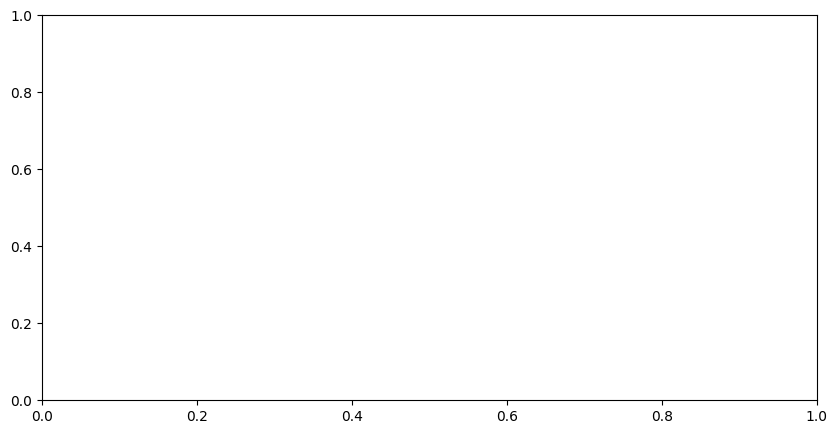

In [50]:
# Create epoch values
epochs = [i for i in range(num_epochs + 1)]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, gen_losses1, label='Generator Loss')
plt.plot(epochs, disc_losses1, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

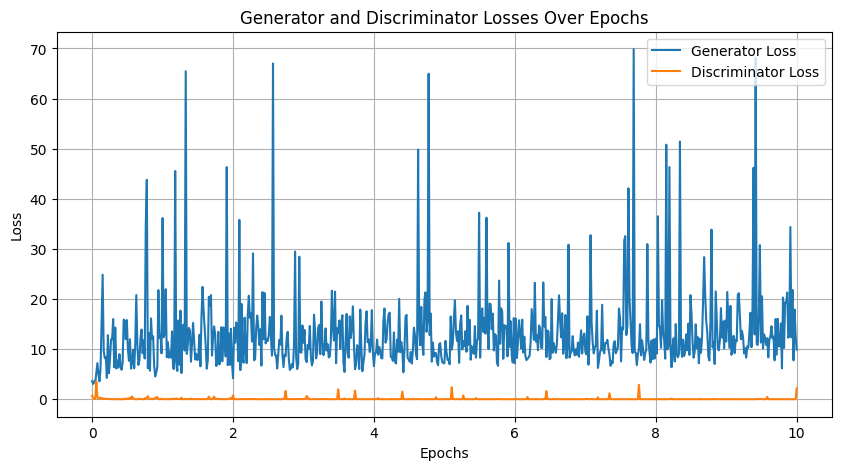

In [53]:
import matplotlib.pyplot as plt

iterations = [(i * 150)/10050 for i in range(len(gen_losses))]

# Plotting the generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(iterations, gen_losses1, label='Generator Loss')
plt.plot(iterations, disc_losses1, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## =================

In [358]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=3)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            features = self.layer1(features)
            features = self.layer2(features)
            features = self.layer3(features)
            image_features.append(features)

        image_features = torch.stack(image_features).permute(1, 0, 2, 3, 4).contiguous()
        return image_features

In [359]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(2048, 512, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(512),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(512, 128, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 8, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 1, kernel_size=1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, image_features):
        image_features = image_features.permute(1, 0, 2, 3, 4).contiguous()
        image_features = torch.split(image_features, 1, dim=0)
        gen_volumes = []
        raw_features = []

        for features in image_features:
            gen_volume = features.view(-1, 2048, 2, 2, 2)
            gen_volume = self.layer1(gen_volume)
            gen_volume = self.layer2(gen_volume)
            gen_volume = self.layer3(gen_volume)
            gen_volume = self.layer4(gen_volume)
            raw_feature = gen_volume
            gen_volume = self.layer5(gen_volume)
            raw_feature = torch.cat((raw_feature, gen_volume), dim=1)

            gen_volumes.append(torch.squeeze(gen_volume, dim=1))
            raw_features.append(raw_feature)

        gen_volumes = torch.stack(gen_volumes).permute(1, 0, 2, 3, 4).contiguous()
        raw_features = torch.stack(raw_features).permute(1, 0, 2, 3, 4, 5).contiguous()
        return raw_features, gen_volumes

In [360]:
def init_weights(m):
    if type(m) == torch.nn.Conv2d or type(m) == torch.nn.Conv3d or type(m) == torch.nn.ConvTranspose3d:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.BatchNorm2d or type(m) == torch.nn.BatchNorm3d:
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, 0, 0.01)
        torch.nn.init.constant_(m.bias, 0)

In [26]:
class UNet3DGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet3DGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # [BATCH, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [BATCH, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [BATCH, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # [BATCH, 512, 8, 8]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Adjust decoder with more layers to upscale depth from 16 to 128
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 256, 32, 64, 64]
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 128, 64, 128, 128]
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 64, 128, 128, 128]
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, output_channels, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 1, 128, 128, 128]
            nn.Tanh()
        )

    def forward(self, x):
        # Apply the 2D encoder
        enc_output = self.encoder(x)
        # Reshape the output from 2D to 3D
        enc_output = enc_output.view(enc_output.size(0), enc_output.size(1), 1, enc_output.size(2), enc_output.size(3))
        # Apply the 3D decoder
        dec_output = self.decoder(enc_output)
        return dec_output


In [27]:
gen=UNet3DGenerator()

In [29]:
gen(batch[0]).shape

torch.Size([1, 1, 16, 128, 128])

In [397]:
class Discriminator3D(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator3D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # [BATCH, 64, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # [BATCH, 128, 32, 32, 32]
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # [BATCH, 256, 16, 16, 16]
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1),  # [BATCH, 512, 8, 8, 8]
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(512, 1, kernel_size=4, stride=2, padding=1),  # [BATCH, 1, 4, 4, 4]
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [404]:
generator = UNet3DGenerator(input_channels=3, output_channels=1)
discriminator = Discriminator3D(input_channels=1)

In [405]:
input_2d = torch.randn((4, 3, 128, 128))  # Example input with BATCH_SIZE=4
output_3d = generator(input_2d)